In [17]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from scipy.stats import norm,halfnorm
import math
from math import log10,floor
import numba

## NeutrinoMass Classes

In [18]:
class DEopt: 
    
    def __init__(self,DE,vol,time,n,eff,b):
        
        self.DE = DE           # Analysis Window
        self.vol = vol         # Volume
        self.time = time       # Runtime (in years)
        self.n = n             # Number Density
        self.eff = eff         # Efficiency Factor
        self.b = b             # Background Rate
        
    def values(self):
        
        eta = 2.00e-13 #Branching Ratio in last eV
        self.b = 3.1536e+7*self.b # s^-1 to yr^-1 conversion
        self.n = self.n*(1.00e+6)
        tau_m = 12.3/np.log(2)
        R = (self.n*self.vol)/tau_m # Decay Rate
        r = self.eff*R*eta # Detected Decay Rate
        
        SD = []
        
        for i in range(len(self.DE)):
            term1 = r*self.time*self.DE[i]
            term2 = (self.b*self.time)/self.DE[i]
            factor = 2/(3*r*self.time)
            SD.append(factor*np.sqrt(term1+term2))
        
        return SD
          
    def min(self):
        
        eta = 2.00e-13 #Branching Ratio in last eV
        self.b = 3.1536e+7*self.b # s^-1 to yr^-1 conversion
        self.n = self.n*(1.00e+6)
        tau_m = 12.3/np.log(2)
        R = (self.n*self.vol)/tau_m # Decay Rate
        r = self.eff*R*eta # Detected Decay Rate
        
        SD = []
        
        for i in range(len(self.DE)):
            term1 = r*self.time*self.DE[i]
            term2 = (self.b*self.time)/self.DE[i]
            factor = 2/(3*r*self.time)
            SD.append(factor*np.sqrt(term1+term2))
        
        
        def rs(x,sig = 2):
            return round(x, sig-int(floor(log10(abs(x))))-1)
        
    
        print("DE_opt = (b/r)^(1/2) = ",rs(np.sqrt(self.b/r), sig = 5))
        
        for i in range(len(SD)):
            if SD[i] < SD[i+1]:
                print("Numerical DE_opt = ",rs((self.DE[i]), sig = 5))
                print("Standard Deviation for numerical DE_opt = ",rs(SD[i],sig = 5))
                break
            else:
                pass   
                
    def plot(self):
        
        DEvals = self.rangevals()
        fig = plt.figure(figsize = (10,8))
        plt.plot(self.DE,DEvals, 'b')
        plt.xlabel("Analysis Window $\\Delta E$", size = 18)
        plt.ylabel("Statistical Uncertainty $\\sigma_{m_\\beta^2}$(stat), eV$^{2}$", size = 18)
        plt.xscale("log")
        plt.yscale("log")
        plt.xticks(size = 16)
        plt.yticks(size = 16)
        plt.title(f"$\\sigma_{{m_\\beta{{^2}}}}$ against $\\Delta E$", size = 20)

class NMevars:
    
    def __init__(self, H3, n , vol , b , time , eff, B, rmsB , u_B , u_s, rmsI, u_I):
        
        # Key Experimental Parameters 
        
        self.H3,self.n,self.vol,self.B,self.time,self.eff,self.b = H3,n,vol,B,time,eff,b
        
        # Resolution in Systematic Uncertainties
        
        self.rmsB,self.rmsI = rmsB,rmsI
        
        # Uncertainties in Key Systematics.
        
        self.u_B,self.u_s,self.u_I = u_B,u_s,u_I
    
    def SDexposure(self):
    
        ''' Constants Relating to Relativistic Dynamics of Decay Electrons'''
        
        # Mass, Cyclotron Frequency, Speed of Light, Tritium Endpoint Energy
        
        mass,f_c,c,E_0 = 9.109e-31,26.5e+9,2.99792458e8,18.6*(1.60e-16) 
        
        # Electron Rest Mass Energy, Lorentz Factor, Relativistic Ratio          
        
        Emc= mass*(c**2)                        
        gamma = 1 + E_0/Emc
        beta = np.sqrt(1-1/(gamma**2))
        ''' -------------------- Tritium Decay Dynamics ---------------------'''
        
        self.n = self.n*(1.00e+6)             # Number Density of Tritium
        yr,eta = 3.1536e+7,2.00e-13
        tau_m = 12.3/np.log(2) # Branching Ratio in Last eV, Mean Lifetime of Tritium
        
        rate = []
        decay_factor = self.eff*(self.n/tau_m)*eta
        
        self.b = yr*self.b
        
        for i in range(len(self.vol)):
            rate.append(decay_factor*self.vol[i]) # Detected Decay Rate due to Efficiency (or "Solid Pitch Angle")
        
        ''' -------------------- Statistical Uncertainty ----------------------'''
        
        ustat,factor,term1,term2 = [],[],[],[]
        DE = 1.0
        #for i in range(len(self.vol)):
            #DE.append(np.sqrt(self.b/rate[i]))
        
        for j in range(len(rate)):
            factor.append(2/(3*rate[j]*self.time))
            term1.append((rate[j]*self.time*DE))
            term2.append((self.b*self.time)/DE)
            ustat.append(factor[j]*np.sqrt(term1[j]+term2[j]))
        

        ''' -------------------- Systematic Uncertainties ----------------------'''
        
        E_end =  18.6e+3                # Endpoint Energy(keV),
        Ey = E_end/(gamma-1)            # Energy Factor
        instr_val = 1.0                 #Instrument Resolution
        instr_res = self.rmsI*instr_val
        ME,IE = Ey*(self.rmsB/self.B), Ey*(instr_res/instr_val) # Magnetic Field and Instrument Systematic Error        
        
        u1,u2,u3 = self.u_B , self.u_s , self.u_I               # Percentage Uncertainties (0.00 - 1.00)

        if self.H3 == "A":
            
            cs = 9.0*(1.00e-19)
            sigma0 = cs*(1.00e-4)
            scat1 = beta*c*sigma0*self.n
            scat2 = 2*np.pi*f_c
            SE = Ey*(scat1/scat2)
        
            systematics = [ME,SE,IE]
            uncertainty = [u1,u2,u3]
            usyst = []
            for i in range(len(systematics)):
                usyst.append((uncertainty[i]**2)*(systematics[i]**4))
            
            usyst = 4*np.sqrt(np.sum((usyst)))
            
            total = []                          # Total Uncertainty
            for j in range(len(ustat)):
                total.append(np.sqrt(ustat[j]**2 + usyst**2))
            
            return total
        
        if self.H3 == "M": 
            
            cs = 3.4*(1.00e-18)
            sigma0 = cs*(1.00e-4)
            scat1 = beta*c*sigma0*self.n
            scat2 = 2*np.pi*f_c
            SE = Ey*(scat1/scat2)
            FSS = 0.30 #0.2978723404255319
                    
            systematics = [ME,SE,FSS,IE]
            uncertainty = [u1,u2,0.01,u3]
            usyst = []
            
            for i in range(len(systematics)):
                usyst.append((uncertainty[i]**2)*(systematics[i]**4))
            
            usyst = 4*np.sqrt(np.sum((usyst)))
            
            total = []                          # Total Uncertainty
            for j in range(len(ustat)):
                total.append(np.sqrt(ustat[j]**2 + usyst**2))
            
            return total
            
    def MSexposure(self,confidence): 
        valsSD = self.SDexposure()
        self.confidence = confidence
        expectation = 0
        # Function will depend on standard deviation
        msv= [] # Mass squared values
        for i in range(len(valsSD)):
            cl = halfnorm.interval(confidence,expectation,valsSD[i])
            msv.append(cl[1])
        mass_vals = np.sqrt(msv)
        return mass_vals
        
    def SDndensity(self):
        ''' Constants Relating to Relativistic Dynamics of Decay Electrons'''
        
        # Mass, Cyclotron Frequency, Speed of Light, Tritium Endpoint Energy
        
        mass,f_c,c,E_0 = 9.109e-31,26.5e+9,2.99792458e8,18.6*(1.60e-16) 
        
        # Electron Rest Mass Energy, Lorentz Factor, Relativistic Ratio          
        
        Emc= mass*(c**2)                        
        gamma = 1 + E_0/Emc
        beta = np.sqrt(1-1/(gamma**2))
        ''' -------------------- Tritium Decay Dynamics ---------------------'''
        
        yr,eta = 3.1536e+7,2.00e-13
        tau_m = 12.3/np.log(2) # Branching Ratio in Last eV, Mean Lifetime of Tritium
        
        rate = []
        decay_factor = self.eff*(self.vol/tau_m)*eta
        
        self.b = yr*self.b
        nm3 = [] # Number Density in Cubic Meters

        for i in range(len(self.n)):
            nm3.append(self.n[i]*1.00e+6)
        for i in range(len(self.n)):
            rate.append(decay_factor*nm3[i]) # Detected Decay Rate due to Efficiency (or "Solid Pitch Angle")
        
        ''' -------------------- Statistical Uncertainty ----------------------'''
        
        ustat,factor,term1,term2 = [],[],[],[]
        DE = 1.0
        
        for j in range(len(self.n)):
            factor.append(2/(3*rate[j]*self.time))
            term1.append((rate[j]*self.time*DE))
            term2.append((self.b*self.time)/DE)
            ustat.append(factor[j]*np.sqrt(term1[j]+term2[j]))
            
        ''' -------------------- Systematic Uncertainties ----------------------'''
        
        E_end =  18.6e+3                # Endpoint Energy(keV),
        Ey = E_end/(gamma-1)            # Energy Factor
        instr_val = 1.0                 #Instrument Resolution
        instr_res = self.rmsI*instr_val
        ME,IE = Ey*(self.rmsB/self.B), Ey*(instr_res/instr_val) # Magnetic Field and Instrument Systematic Error        
        
        u1,u2,u3 = self.u_B , self.u_s , self.u_I               # Percentage Uncertainties (0.00 - 1.00)

        if self.H3 == "A":
            
            scat2 = 2*np.pi*f_c
            cs = 9.0*(1.00e-19)
            sigma0 = cs*(1.00e-4)
            
            SE = []
            usyst1,usyst2 = [], []
            scat1 = []
            for i in range(len(self.n)):
                scat1.append(beta*c*sigma0*nm3[i])
            for i in range(len(self.n)):
                SE.append(Ey*(scat1[i]/scat2))
                usyst1.append((ME**4)*(u1**2) + (SE[i]**4)*(u2**2) + (IE**4)*(u3**2))
                usyst2.append(4*np.sqrt(usyst1[i]))
            
            total = []                          # Total Uncertainty
            for j in range(len(self.n)):
                total.append(np.sqrt(ustat[j]**2 + usyst2[j]**2))
            
            return total
        
        if self.H3 == "M":
            
            
            scat2 = 2*np.pi*f_c
            cs = 3.4*(1.00e-18)
            sigma0 = cs*(1.00e-4)
            FSS = 0.30
            
            SE = []
            usyst1,usyst2 = [], []
            scat1 = []
            for i in range(len(self.n)):
                scat1.append(beta*c*sigma0*nm3[i])
            for i in range(len(self.n)):
                SE.append(Ey*(scat1[i]/scat2))
                usyst1.append((ME**4)*(u1**2) + (SE[i]**4)*(u2**2) + (IE**4)*(u3**2) + (FSS**4)*(0.01**2))
                usyst2.append(4*np.sqrt(usyst1[i]))
            
            total = []                          # Total Uncertainty
            for j in range(len(self.n)):
                total.append(np.sqrt(ustat[j]**2 + usyst2[j]**2))
            
            return total
               
    def MSndensity(self,confidence):
        valsSD = self.SDndensity()
        self.confidence = confidence
        expectation = 0
        # Function will depend on standard deviation
        msv= [] # Mass squared values
        for i in range(len(valsSD)):
            cl = halfnorm.interval(confidence,expectation,valsSD[i])
            msv.append(cl[1])
        mass_vals = np.sqrt(msv)
        return mass_vals

    def MSndensity_opt(self,confidence):
        self.confidence = confidence
        valsMS = self.MSndensity(self.confidence)
        expectation = 0
        # Function will depend on standard deviation
        msv= [] # Mass squared values
       
        for i in range(len(valsMS)):
            if valsMS[i] < valsMS[i+1]:
                print("Optimum Number Density", self.n[i])
                print("Minimum Neutrino Mass at Optimum n ",valsMS[i], "eV")
                break
         
    def SDbackground(self):
        
        ''' Constants Relating to Relativistic Dynamics of Decay Electrons'''
        
        # Mass, Cyclotron Frequency, Speed of Light, Tritium Endpoint Energy
        
        mass,f_c,c,E_0 = 9.109e-31,26.5e+9,2.99792458e8,18.6*(1.60e-16) 
        
        # Electron Rest Mass Energy, Lorentz Factor, Relativistic Ratio          
        
        Emc= mass*(c**2)                        
        gamma = 1 + E_0/Emc
        beta = np.sqrt(1-1/(gamma**2))
        ''' -------------------- Tritium Decay Dynamics ---------------------'''
        
        self.n = self.n*(1.00e+6)             # Number Density of Tritium
        yr,eta = 3.1536e+7,2.00e-13
        tau_m = 12.3/np.log(2) # Branching Ratio in Last eV, Mean Lifetime of Tritium
    
        rate = self.eff*(self.n*self.vol/tau_m)*eta
        
        back = []
        for i in range(len(self.b)):
            back.append(yr*self.b[i])
            
        
    
        ''' -------------------- Statistical Uncertainty ----------------------'''
        
        DE = 1.0
        factor = 2/(3*rate*self.time)
        term1 = rate*self.time*DE
        ustat,term2 = [],[]
        
        for j in range(len(back)):
            term2.append((back[j]*self.time)/DE)
            ustat.append(factor*np.sqrt(term1+term2[j]))
        
        ''' -------------------- Systematic Uncertainties ----------------------'''
        
        E_end =  18.6e+3                # Endpoint Energy(keV),
        Ey = E_end/(gamma-1)            # Energy Factor
        instr_val = 1.0                 #Instrument Resolution
        instr_res = self.rmsI*instr_val
        ME,IE = Ey*(self.rmsB/self.B), Ey*(instr_res/instr_val) # Magnetic Field and Instrument Systematic Error        
        
        u1,u2,u3 = self.u_B , self.u_s , self.u_I               # Percentage Uncertainties (0.00 - 1.00)

        if self.H3 == "A":
            
            cs = 9.0*(1.00e-19)
            sigma0 = cs*(1.00e-4)
            scat1 = beta*c*sigma0*self.n
            scat2 = 2*np.pi*f_c
            SE = Ey*(scat1/scat2)
        
            systematics = [ME,SE,IE]
            uncertainty = [u1,u2,u3]
            usyst = []
            for i in range(len(systematics)):
                usyst.append((uncertainty[i]**2)*(systematics[i]**4))
            
            usyst = 4*np.sqrt(np.sum((usyst)))
            
            total = []                          # Total Uncertainty
            for j in range(len(ustat)):
                total.append(np.sqrt(ustat[j]**2 + usyst**2))
            
            return total
        
        if self.H3 == "M": 
            
            cs = 3.4*(1.00e-18)
            sigma0 = cs*(1.00e-4)
            scat1 = beta*c*sigma0*self.n
            scat2 = 2*np.pi*f_c
            SE = Ey*(scat1/scat2)
            FSS = 0.30 #0.2978723404255319
                  
            systematics = [ME,SE,FSS,IE]
            uncertainty = [u1,u2,0.01,u3]
            usyst = []
            
            for i in range(len(systematics)):
                usyst.append((uncertainty[i]**2)*(systematics[i]**4))
            
            usyst = 4*np.sqrt(np.sum((usyst)))
            
            total = []                          # Total Uncertainty
            for j in range(len(ustat)):
                total.append(np.sqrt(ustat[j]**2 + usyst**2))
            
            return total
        
    def MSbackground(self,confidence):
        valsSD = self.SDbackground()
        self.confidence = confidence
        expectation = 0
        # Function will depend on standard deviation
        msv= [] # Mass squared values
        for i in range(len(valsSD)):
            cl = halfnorm.interval(confidence,expectation,valsSD[i])
            msv.append(cl[1])
        mass_vals = np.sqrt(msv)
        mass_vals1 = []
        for i in range(len(mass_vals)):
            mass_vals1.append(mass_vals[i]*1000)
        return mass_vals1
    
class NMuvars1:
    
    def __init__(self, H3, n , vol , b , time , eff, B, rmsB , u_B , u_s, rmsI, u_I):
        
        # Experimental Parameters
        self.H3, self.n , self.vol, self.time, self.eff , self.B,self.b = H3 , n , vol, time, eff,B,b
        
        # Variation (Uncertainty) with the instrumentals

        self.rmsB = rmsB
        self.rmsI = rmsI

        # Uncertainty on rms Variation 

        self.u_B = u_B
        self.u_I = u_I
        self.u_s = u_s
        
    def SDscattering(self):
       
        ''' Constants Relating to Relativistic Dynamics of Decay Electrons'''
        
        # Mass, Cyclotron Frequency, Speed of Light, Tritium Endpoint Energy
        
        mass,f_c,c,E_0 = 9.109e-31,26.5e+9,2.99792458e8,18.6*(1.60e-16) 
        
        # Electron Rest Mass Energy, Lorentz Factor, Relativistic Ratio          
        
        Emc= mass*(c**2)                        
        gamma = 1 + E_0/Emc
        beta = np.sqrt(1-1/(gamma**2))
        ''' -------------------- Tritium Decay Dynamics ---------------------'''
        
        yr,eta = 3.1536e+7,2.00e-13
        tau_m = 12.3/np.log(2) # Branching Ratio in Last eV, Mean Lifetime of Tritium
        
        self.b = yr*self.b
        self.n = self.n*(1.00e+6)

        rate = self.eff*(self.vol*self.n/tau_m)*eta
        
        ''' -------------------- Statistical Uncertainty ----------------------'''
        
        DE = 1.00e0
        factor = 2/(3*rate*self.time)
        term1 = rate*self.time*DE
        term2 = (self.b*self.time)/DE
        ustat = factor*np.sqrt(term1 + term2)
       
        ''' -------------------- Systematic Uncertainties ----------------------'''
        
        E_end =  18.6e+3                # Endpoint Energy(keV),
        Ey = E_end/(gamma-1)            # Energy Factor
        instr_val = 1.0                 #Instrument Resolution
        instr_res = self.rmsI*instr_val
        ME,IE = Ey*(self.rmsB/self.B), Ey*(instr_res/instr_val) # Magnetic Field and Instrument Systematic Error        
        
        if self.H3 == "A":
            
            cs = 9.0*(1.00e-19)
            sigma0 = cs*(1.00e-4)
            scat1 = beta*c*sigma0*self.n
            scat2 = 2*np.pi*f_c
            SE = Ey*(scat1/scat2)

            SEsyst = []
            for i in range(len(self.u_s)):
                SEsyst.append((SE**4)*(self.u_s[i]**2))

            usyst1,usyst2 = [],[]
         
            for j in range(len(self.u_s)):
                usyst1.append((ME**4)*(self.u_B**2) + SEsyst[j] + (IE**4)*(self.u_I**2))
                usyst2.append(4*np.sqrt(usyst1[j]))
            
            total = []                          # Total Uncertainty
            for j in range(len(self.u_s)):
                total.append(np.sqrt(ustat**2 + usyst2[j]**2))
            
            return total
        
        if self.H3 == "M":
            
            scat2 = 2*np.pi*f_c
            cs = 3.4*(1.00e-18)
            sigma0 = cs*(1.00e-4)
            FSS = 0.30
            scat1 = beta*c*sigma0*self.n
            scat2 = 2*np.pi*f_c
            SE = Ey*(scat1/scat2)

            SEsyst = []
            for i in range(len(self.u_s)):
                SEsyst.append((SE**4)*(self.u_s[i]**2))

            usyst1,usyst2 = [],[]
         
            for j in range(len(self.u_s)):
                usyst1.append((ME**4)*(self.u_B**2) + SEsyst[j] + (IE**4)*(self.u_I**2)+(FSS**4)*(0.01**2))
                usyst2.append(4*np.sqrt(usyst1[j]))
            
            total = []                          # Total Uncertainty
            for j in range(len(self.u_s)):
                total.append(np.sqrt(ustat**2 + usyst2[j]**2))
            
            return total
    
    def MSscattering(self,confidence):
        valsSD = self.SDscattering()
        self.confidence = confidence
        expectation = 0
        # Function will depend on standard deviation
        msv= [] # Mass squared values
        for i in range(len(valsSD)):
            cl = halfnorm.interval(confidence,expectation,valsSD[i])
            msv.append(cl[1])
        mass_vals = np.sqrt(msv)
        return mass_vals
    
    def SDmagnetic(self):
        
        ''' Constants Relating to Relativistic Dynamics of Decay Electrons'''
        
        # Mass, Cyclotron Frequency, Speed of Light, Tritium Endpoint Energy
        
        mass,f_c,c,E_0 = 9.109e-31,26.5e+9,2.99792458e8,18.6*(1.60e-16) 
        
        # Electron Rest Mass Energy, Lorentz Factor, Relativistic Ratio          
        
        Emc= mass*(c**2)                        
        gamma = 1 + E_0/Emc
        beta = np.sqrt(1-1/(gamma**2))
        ''' -------------------- Tritium Decay Dynamics ---------------------'''
        
        yr,eta = 3.1536e+7,2.00e-13
        tau_m = 12.3/np.log(2) # Branching Ratio in Last eV, Mean Lifetime of Tritium
        
        self.b = yr*self.b
        self.n = self.n*(1.00e+6)

        rate = self.eff*(self.vol*self.n/tau_m)*eta
        
        ''' -------------------- Statistical Uncertainty ----------------------'''
        
        DE = 1.00e0
        factor = 2/(3*rate*self.time)
        term1 = rate*self.time*DE
        term2 = (self.b*self.time)/DE
        ustat = factor*np.sqrt(term1 + term2)
       
        ''' -------------------- Systematic Uncertainties ----------------------'''
        
        E_end =  18.6e+3                # Endpoint Energy(keV),
        Ey = E_end/(gamma-1)            # Energy Factor
        instr_val = 1.0                 #Instrument Resolution
        instr_res = self.rmsI*instr_val
        ME,IE = Ey*(self.rmsB/self.B), Ey*(instr_res/instr_val) # Magnetic Field and Instrument Systematic Error  
        
        if self.H3 == "A":
            
            cs = 9.0*(1.00e-19)
            sigma0 = cs*(1.00e-4)
            scat1 = beta*c*sigma0*self.n
            scat2 = 2*np.pi*f_c
            SE = Ey*(scat1/scat2)

            MEsyst = []
            for i in range(len(self.u_B)):
                MEsyst.append((ME**4)*(self.u_B[i]**2))

            usyst1,usyst2 = [],[]
         
            for j in range(len(self.u_B)):
                usyst1.append((SE**4)*(self.u_s**2) + MEsyst[j] + (IE**4)*(self.u_I**2))
                usyst2.append(4*np.sqrt(usyst1[j]))
            
            total = []                          # Total Uncertainty
            for j in range(len(self.u_B)):
                total.append(np.sqrt(ustat**2 + usyst2[j]**2))
            
            return total
        
        if self.H3 == "M":
            
            scat2 = 2*np.pi*f_c
            cs = 3.4*(1.00e-18)
            sigma0 = cs*(1.00e-4)
            FSS = 0.30
            scat1 = beta*c*sigma0*self.n
            scat2 = 2*np.pi*f_c
            SE = Ey*(scat1/scat2)

            MEsyst = []
            for i in range(len(self.u_B)):
                MEsyst.append((ME**4)*(self.u_B[i]**2))

            usyst1,usyst2 = [],[]
         
            for j in range(len(self.u_B)):
                usyst1.append((SE**4)*(self.u_s**2) + MEsyst[j] + (IE**4)*(self.u_I**2)+(FSS**4)*(0.01**2))
                usyst2.append(4*np.sqrt(usyst1[j]))
            
            total = []                          # Total Uncertainty
            for j in range(len(self.u_B)):
                total.append(np.sqrt(ustat**2 + usyst2[j]**2))
            
            return total
    
    def MSmagnetic(self,confidence):
        valsSD = self.SDmagnetic()
        self.confidence = confidence
        expectation = 0
        # Function will depend on standard deviation
        msv= [] # Mass squared values
        for i in range(len(valsSD)):
            cl = halfnorm.interval(confidence,expectation,valsSD[i])
            msv.append(cl[1])
        mass_vals = np.sqrt(msv)
        return mass_vals
    
    def SDinstrument(self):
        ''' Constants Relating to Relativistic Dynamics of Decay Electrons'''
        
        # Mass, Cyclotron Frequency, Speed of Light, Tritium Endpoint Energy
        
        mass,f_c,c,E_0 = 9.109e-31,26.5e+9,2.99792458e8,18.6*(1.60e-16) 
        
        # Electron Rest Mass Energy, Lorentz Factor, Relativistic Ratio          
        
        Emc= mass*(c**2)                        
        gamma = 1 + E_0/Emc
        beta = np.sqrt(1-1/(gamma**2))
        ''' -------------------- Tritium Decay Dynamics ---------------------'''
        
        yr,eta = 3.1536e+7,2.00e-13
        tau_m = 12.3/np.log(2) # Branching Ratio in Last eV, Mean Lifetime of Tritium
        
        self.b = yr*self.b
        self.n = self.n*(1.00e+6)

        rate = self.eff*(self.vol*self.n/tau_m)*eta
        
        ''' -------------------- Statistical Uncertainty ----------------------'''
        
        DE = 1.00e0
        factor = 2/(3*rate*self.time)
        term1 = rate*self.time*DE
        term2 = (self.b*self.time)/DE
        ustat = factor*np.sqrt(term1 + term2)
       
        ''' -------------------- Systematic Uncertainties ----------------------'''
        
        E_end =  18.6e+3                # Endpoint Energy(keV),
        Ey = E_end/(gamma-1)            # Energy Factor
        instr_val = 1.0                 #Instrument Resolution
        instr_res = self.rmsI*instr_val
        ME,IE = Ey*(self.rmsB/self.B), Ey*(instr_res/instr_val) # Magnetic Field and Instrument Systematic Error  
        
        if self.H3 == "A":
            
            cs = 9.0*(1.00e-19)
            sigma0 = cs*(1.00e-4)
            scat1 = beta*c*sigma0*self.n
            scat2 = 2*np.pi*f_c
            SE = Ey*(scat1/scat2)

            IEsyst = []
            for i in range(len(self.u_I)):
                IEsyst.append((IE**4)*(self.u_I[i]**2))

            usyst1,usyst2 = [],[]
         
            for j in range(len(self.u_I)):
                usyst1.append((SE**4)*(self.u_s**2) + IEsyst[j] + (ME**4)*(self.u_B**2))
                usyst2.append(4*np.sqrt(usyst1[j]))
            
            total = []                          # Total Uncertainty
            for j in range(len(self.u_I)):
                total.append(np.sqrt(ustat**2 + usyst2[j]**2))
            
            return total
        
        if self.H3 == "M":
            
            scat2 = 2*np.pi*f_c
            cs = 3.4*(1.00e-18)
            sigma0 = cs*(1.00e-4)
            FSS = 0.30
            scat1 = beta*c*sigma0*self.n
            scat2 = 2*np.pi*f_c
            SE = Ey*(scat1/scat2)

            IEsyst = []
            for i in range(len(self.u_I)):
                IEsyst.append((IE**4)*(self.u_I[i]**2))

            usyst1,usyst2 = [],[]
         
            for j in range(len(self.u_I)):
                usyst1.append((SE**4)*(self.u_s**2) + IEsyst[j] + (ME**4)*(self.u_B**2)+(FSS**4)*(0.01**2))
                usyst2.append(4*np.sqrt(usyst1[j]))
            
            total = []                          # Total Uncertainty
            for j in range(len(self.u_I)):
                total.append(np.sqrt(ustat**2 + usyst2[j]**2))
            
            return total
    
    def MSinstrument(self,confidence):
        valsSD = self.SDinstrument()
        self.confidence = confidence
        expectation = 0
        # Function will depend on standard deviation
        msv= [] # Mass squared values
        for i in range(len(valsSD)):
            cl = halfnorm.interval(confidence,expectation,valsSD[i])
            msv.append(cl[1])
        mass_vals = np.sqrt(msv)
        return mass_vals
 
class NMuvars2:
    
    def __init__(self, H3, n , vol , b , time , eff, B, rmsB , u_B , u_s, rmsI, u_I):
        
        # Experimental Parameters
        self.H3, self.n , self.vol, self.time, self.eff , self.B,self.b = H3 , n , vol, time, eff,B,b
        
        # Variation (Uncertainty) with the instrumentals

        self.rmsB = rmsB
        self.rmsI = rmsI

        # Uncertainty on rms Variation 

        self.u_B = u_B
        self.u_I = u_I
        self.u_s = u_s
        
    def SDres_magnetic(self):
        
        ''' Constants Relating to Relativistic Dynamics of Decay Electrons'''
        
        # Mass, Cyclotron Frequency, Speed of Light, Tritium Endpoint Energy
        
        mass,f_c,c,E_0 = 9.109e-31,26.5e+9,2.99792458e8,18.6*(1.60e-16) 
        
        # Electron Rest Mass Energy, Lorentz Factor, Relativistic Ratio          
        
        Emc= mass*(c**2)                        
        gamma = 1 + E_0/Emc
        beta = np.sqrt(1-1/(gamma**2))
        ''' -------------------- Tritium Decay Dynamics ---------------------'''
        
        yr,eta = 3.1536e+7,2.00e-13
        tau_m = 12.3/np.log(2) # Branching Ratio in Last eV, Mean Lifetime of Tritium
        
        self.b = yr*self.b
        self.n = self.n*(1.00e+6)

        rate = self.eff*(self.vol*self.n/tau_m)*eta
        
        ''' -------------------- Statistical Uncertainty ----------------------'''
        
        DE = 1.00e0
        factor = 2/(3*rate*self.time)
        term1 = rate*self.time*DE
        term2 = (self.b*self.time)/DE
        ustat = factor*np.sqrt(term1 + term2)
       
        ''' -------------------- Systematic Uncertainties ----------------------'''
        
        E_end =  18.6e+3                # Endpoint Energy(keV),
        Ey = E_end/(gamma-1)            # Energy Factor
        instr_val = 1.0                 #Instrument Resolution
        instr_res = self.rmsI*instr_val
        
        ME = []
        for i in range(len(self.rmsB)):
            ME.append(Ey*(self.rmsB[i]/self.B))
            
        IE = Ey*(instr_res/instr_val) # Magnetic Field and Instrument Systematic Error  
        
        if self.H3 == "A":
            
            cs = 9.0*(1.00e-19)
            sigma0 = cs*(1.00e-4)
            scat1 = beta*c*sigma0*self.n
            scat2 = 2*np.pi*f_c
            SE = Ey*(scat1/scat2)
            MEsyst = []
            for i in range(len(self.rmsB)):
                MEsyst.append((ME[i]**4)*(self.u_B**2))

            usyst1,usyst2 = [],[]
         
            for j in range(len(self.rmsB)):
                usyst1.append((SE**4)*(self.u_s**2) + MEsyst[j] + (IE**4)*(self.u_I**2))
                usyst2.append(4*np.sqrt(usyst1[j]))
            
            total = []                          # Total Uncertainty
            for j in range(len(self.rmsB)):
                total.append(np.sqrt(ustat**2 + usyst2[j]**2))
            
            return total
        
        if self.H3 == "M":
            
            scat2 = 2*np.pi*f_c
            cs = 3.4*(1.00e-18)
            sigma0 = cs*(1.00e-4)
            FSS = 0.30
            scat1 = beta*c*sigma0*self.n
            scat2 = 2*np.pi*f_c
            SE = Ey*(scat1/scat2)

            MEsyst = []
            for i in range(len(self.rmsB)):
                MEsyst.append((ME[i]**4)*(self.u_B**2))

            usyst1,usyst2 = [],[]
         
            for j in range(len(self.rmsB)):
                usyst1.append((SE**4)*(self.u_s**2) + MEsyst[j] + (IE**4)*(self.u_I**2)+(FSS**4)*(0.01**2))
                usyst2.append(4*np.sqrt(usyst1[j]))
            
            total = []                          # Total Uncertainty
            for j in range(len(self.u_B)):
                total.append(np.sqrt(ustat**2 + usyst2[j]**2))
            
            return total
    
    def MSres_magnetic(self,confidence):
        valsSD = self.SDres_magnetic()
        self.confidence = confidence
        expectation = 0
        # Function will depend on standard deviation
        msv= [] # Mass squared values
        for i in range(len(valsSD)):
            cl = halfnorm.interval(confidence,expectation,valsSD[i])
            msv.append(cl[1])
        mass_vals = np.sqrt(msv)
        return mass_vals
    
    def SDres_instrument(self):
        ''' Constants Relating to Relativistic Dynamics of Decay Electrons'''
        
        # Mass, Cyclotron Frequency, Speed of Light, Tritium Endpoint Energy
        
        mass,f_c,c,E_0 = 9.109e-31,26.5e+9,2.99792458e8,18.6*(1.60e-16) 
        
        # Electron Rest Mass Energy, Lorentz Factor, Relativistic Ratio          
        
        Emc= mass*(c**2)                        
        gamma = 1 + E_0/Emc
        beta = np.sqrt(1-1/(gamma**2))
        ''' -------------------- Tritium Decay Dynamics ---------------------'''
        
        yr,eta = 3.1536e+7,2.00e-13
        tau_m = 12.3/np.log(2) # Branching Ratio in Last eV, Mean Lifetime of Tritium
        
        self.b = yr*self.b
        self.n = self.n*(1.00e+6)

        rate = self.eff*(self.vol*self.n/tau_m)*eta
        
        ''' -------------------- Statistical Uncertainty ----------------------'''
        
        DE = 1.00e0
        factor = 2/(3*rate*self.time)
        term1 = rate*self.time*DE
        term2 = (self.b*self.time)/DE
        ustat = factor*np.sqrt(term1 + term2)
       
        ''' -------------------- Systematic Uncertainties ----------------------'''
        
        E_end =  18.6e+3                # Endpoint Energy(keV),
        Ey = E_end/(gamma-1)            # Energy Factor
        instr_val = 1.0                 #Instrument Resolution
        #instr_res = self.rmsI*instr_val
        ME = Ey*(self.rmsB/self.B)
        IE = []
        for i in range(len(self.rmsI)):
            IE.append(Ey*(self.rmsI[i]*instr_val))
        
        if self.H3 == "A":
            
            cs = 9.0*(1.00e-19)
            sigma0 = cs*(1.00e-4)
            scat1 = beta*c*sigma0*self.n
            scat2 = 2*np.pi*f_c
            SE = Ey*(scat1/scat2)
            IEsyst = []
            for i in range(len(self.rmsI)):
                IEsyst.append((IE[i]**4)*(self.u_I**2))

            usyst1,usyst2 = [],[]
         
            for j in range(len(self.rmsI)):
                usyst1.append((SE**4)*(self.u_s**2) + IEsyst[j] + (ME**4)*(self.u_B**2))
                usyst2.append(4*np.sqrt(usyst1[j]))
            
            total = []                          # Total Uncertainty
            for j in range(len(self.rmsI)):
                total.append(np.sqrt(ustat**2 + usyst2[j]**2))
            
            return total
        
        if self.H3 == "M":
            
            FSS = 0.30
            cs = 9.0*(1.00e-19)
            sigma0 = cs*(1.00e-4)
            scat1 = beta*c*sigma0*self.n
            scat2 = 2*np.pi*f_c
            SE = Ey*(scat1/scat2)
            
            IEsyst = []
            for i in range(len(self.rmsI)):
                IEsyst.append((IE[i]**4)*(self.u_I**2))
           
            usyst1,usyst2 = [],[]
         
            for j in range(len(self.rmsI)):
                usyst1.append((SE**4)*(self.u_s**2) + IEsyst[j] + (ME**4)*(self.u_B**2)++(FSS**4)*(0.01**2))
                usyst2.append(4*np.sqrt(usyst1[j]))
            
            total = []                          # Total Uncertainty
            for j in range(len(self.rmsI)):
                total.append(np.sqrt(ustat**2 + usyst2[j]**2))
             
            return total
    
    def MSres_instrument(self,confidence):
        valsSD = self.SDres_instrument()
        self.confidence = confidence
        expectation = 0
        # Function will depend on standard deviation
        msv= [] # Mass squared values
        for i in range(len(valsSD)):
            cl = halfnorm.interval(confidence,expectation,valsSD[i])
            msv.append(cl[1])
        mass_vals = np.sqrt(msv)
        return mass_vals
 
 
def NMfinmass(H3, n , vol , b , time , eff, B, rmsB , u_B , u_s, rmsI, u_I,confidence):
    
    ''' Constants Relating to Relativistic Dynamics of Decay Electrons'''
        
    # Mass, Cyclotron Frequency, Speed of Light, Tritium Endpoint Energy
    
    mass,f_c,c,E_0 = 9.109e-31,26.5e+9,2.99792458e8,18.6*(1.60e-16) 
    
    # Electron Rest Mass Energy, Lorentz Factor, Relativistic Ratio          
        
    Emc= mass*(c**2)                        
    gamma = 1 + E_0/Emc
    beta = np.sqrt(1-1/(gamma**2))
    ''' -------------------- Tritium Decay Dynamics ---------------------'''
    
    yr,eta = 3.1536e+7,2.00e-13
    tau_m = 12.3/np.log(2) # Branching Ratio in Last eV, Mean Lifetime of Tritium
    
    b = yr*b
    n = n*(1.00e+6)

    rate = eff*(vol*n/tau_m)*eta
    
    ''' -------------------- Statistical Uncertainty ----------------------'''
    
    DE = 1.00e0
    factor = 2/(3*rate*time)
    term1 = rate*time*DE
    term2 = (b*time)/DE
    ustat = factor*np.sqrt(term1 + term2)
    
    ''' -------------------- Systematic Uncertainties ----------------------'''
    
    E_end =  18.6e+3                # Endpoint Energy(keV),
    Ey = E_end/(gamma-1)            # Energy Factor
    instr_val = 1.0                 #Instrument Resolution
    instr_res = rmsI*instr_val
    ME,IE = Ey*(rmsB/B), Ey*(instr_res/instr_val) # Magnetic Field and Instrument Systematic Error        
    
    u1,u2,u3 = u_B , u_s , u_I               # Percentage Uncertainties (0.00 - 1.00)

    if H3 == "A":
        
        cs = 9.0*(1.00e-19)
        sigma0 = cs*(1.00e-4)
        scat1 = beta*c*sigma0*n
        scat2 = 2*np.pi*f_c
        SE = Ey*(scat1/scat2)
    
        systematics = [ME,SE,IE]
        uncertainty = [u1,u2,u3]
        usyst = []
        for i in range(len(systematics)):
            usyst.append((uncertainty[i]**2)*(systematics[i]**4))
        
        usyst = 4*np.sqrt(np.sum((usyst)))
        total = np.sqrt(ustat**2 + usyst**2)
        expectation = 0
        cl = halfnorm.interval(confidence,expectation,total)
        mass_vals = np.sqrt(cl[1])
        print(mass_vals*1000,"meV")
    if H3 == "M": 
        
        cs = 3.4*(1.00e-18)
        sigma0 = cs*(1.00e-4)
        scat1 = beta*c*sigma0*n
        scat2 = 2*np.pi*f_c
        SE = Ey*(scat1/scat2)
        FSS = 0.30 #0.2978723404255319
                
        systematics = [ME,SE,FSS,IE]
        uncertainty = [u1,u2,0.01,u3]
        usyst = []
        
        for i in range(len(systematics)):
            usyst.append((uncertainty[i]**2)*(systematics[i]**4))
        
        usyst = 4*np.sqrt(np.sum((usyst)))
        total = np.sqrt(ustat**2 + usyst**2)
        expectation = 0
        cl = halfnorm.interval(confidence,expectation,total)
        mass_vals = np.sqrt(cl[1])
        print(mass_vals*1000,"meV")
    
    
        
 
    

   


## Analysis Window $\Delta E$ plots

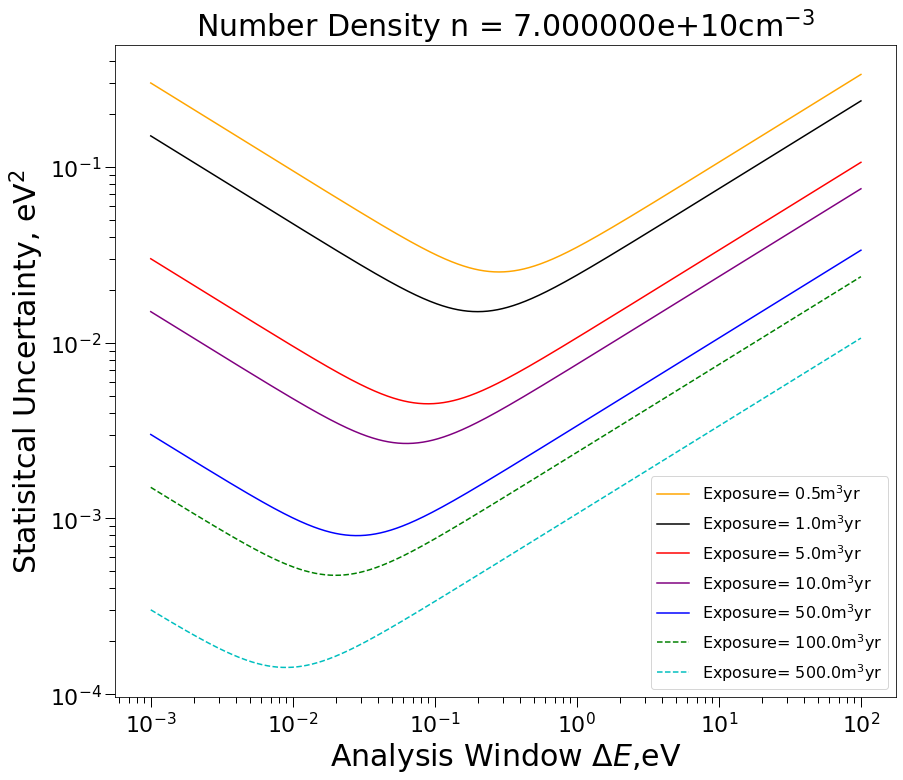

In [19]:
# DE Opt Variables

DE = np.logspace(-3,2,num = 1000)

vol = [1.0,5.0,10.0,50.0,100.0,500.0,1000.0]
n = [7.00e+10,1.00e+11,7.00e+11,1.00e+12]
t = 1.00
b = 1.00e-6
eff = 1.00
exp = [] # Exposure
def DEcomps(n):
    
    DE = np.logspace(-3,2,num = 1000)
    vol = [1.0,5.0,10.0,50.0,100.0,500.0,1000.0]
    
    t = 1.00
    b = 1.00e-6
    eff = 1.00
    
    vol = [0.5,1.0,5.0,10.0,50.0,100.0,500.0,1000.0]
    DE11 = DEopt(DE,vol[0],t,n,eff,b).values()
    DE12 = DEopt(DE,vol[1],t,n,eff,b).values()
    DE13 = DEopt(DE,vol[2],t,n,eff,b).values()
    DE14 = DEopt(DE,vol[3],t,n,eff,b).values()
    DE15 = DEopt(DE,vol[4],t,n,eff,b).values()
    DE16 = DEopt(DE,vol[5],t,n,eff,b).values()
    DE17 = DEopt(DE,vol[6],t,n,eff,b).values()
    DE18 = DEopt(DE,vol[7],t,n,eff,b).values()

    fig = plt.figure(figsize = (14,12))   
    plt.plot(DE,DE11, "orange")
    plt.plot(DE,DE12, "k")
    plt.plot(DE,DE13, "r")
    plt.plot(DE,DE14, "purple")
    plt.plot(DE,DE15, "b")
    plt.plot(DE,DE16, "g--")
    plt.plot(DE,DE17, "c--")
    plt.xlabel("Analysis Window $\\Delta E$,eV", size = 30)
    plt.ylabel("Statisitcal Uncertainty, eV$^{{2}}$", size = 30)
    plt.xscale("log")
    plt.yscale("log")
    plt.xticks(size = 22)
    plt.yticks(size = 22)
    plt.tick_params(axis = 'both', which = 'major',length = 10, width = 1)
    plt.tick_params(axis = 'both', which = 'minor',length = 6, width = 1)
    def rs(x,sig = 3):
            return round(x, sig-int(floor(log10(abs(x))))-1)
    n1 = rs(n)
    plt.title(f"Number Density n = {n1:e}cm$^{{-3}}$", size = 30)
    
    legends = []
    for i in range(len(vol)):
        legends.append(f'Exposure= {vol[i]}m$^{{3}}$yr')
        
    plt.legend(legends, fontsize = 16)


for i in range(len(n)):
    DEcomps

DEcomps(n[0])
    

## $m_\beta$ as a function of exposure

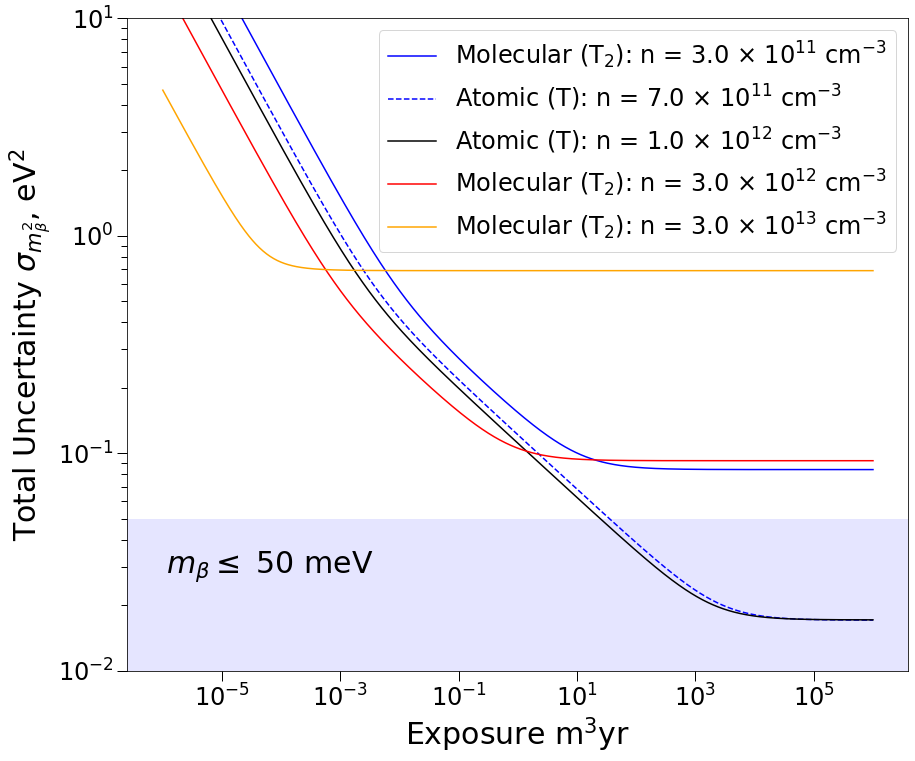

In [20]:
n = [3.00e+11,7.00e+11,1.00e+12,3.00e+12,3.00e+13]
vol = np.logspace(-6,6,num = 1000)
b = 1.00e-6
B = t = eff = 1.00e0
exp = []
rmsB = B*1.00e-7
rmsI = 1.00e-7
ui = ub = us = 1.00e-2
cl = 0.90

for i in range(len(vol)):
    exp.append(vol[i]*eff*t)

nm1 = NMevars("M",n[0],vol,b,t,eff,B,rmsB,ub,us,rmsI,ui).MSexposure(cl)
nm2 = NMevars("A",n[1],vol,b,t,eff,B,rmsB,ub,us,rmsI,ui).MSexposure(cl)
nm3 = NMevars("A",n[2],vol,b,t,eff,B,rmsB,ub,us,rmsI,ui).MSexposure(cl)
nm4 = NMevars("M",n[3],vol,b,t,eff,B,rmsB,ub,us,rmsI,ui).MSexposure(cl)
nm5 = NMevars("M",n[4],vol,b,t,eff,B,rmsB,ub,us,rmsI,ui).MSexposure(cl)


fig = plt.figure(figsize = (14,12))
plt.plot(exp,nm1, "b")
plt.plot(exp,nm2, "b--")
plt.plot(exp,nm3, "k")
plt.plot(exp,nm4, "r")
plt.plot(exp,nm5, "orange")
plt.xlabel("Exposure m$^{{3}}$yr", size = 30)
plt.ylabel("Total Uncertainty $\\sigma_{m_\\beta^2}$, eV$^{{2}}$", size = 30)
plt.xscale("log")
plt.yscale("log")
plt.ylim((1e-2,1e1))
plt.tick_params(axis = 'both', which = 'major',length = 10, width = 1)
plt.tick_params(axis = 'both', which = 'minor',length = 6, width = 1)
plt.axhspan(1e-2,5e-2,facecolor='blue', alpha=0.1)
ax = plt.subplot(111)
t = plt.text(0.05, 0.15, '$m_\\beta \\leq$ 50 meV', transform=ax.transAxes, fontsize=30)
t.set_bbox(dict(facecolor='none', alpha=0.1, edgecolor='none'))
plt.xticks(size = 24)
plt.yticks(size = 24)
plt.legend(['Molecular (T$_2$): n = 3.0 $\\times$ 10$^{{11}}$ cm$^{{-3}}$',
            'Atomic (T): n = 7.0 $\\times$ 10$^{{11}}$ cm$^{{-3}}$',
            'Atomic (T): n = 1.0 $\\times$ 10$^{{12}}$ cm$^{{-3}}$',
            'Molecular (T$_2$): n = 3.0 $\\times$ 10$^{{12}}$ cm$^{{-3}}$',
            'Molecular (T$_2$): n = 3.0 $\\times$ 10$^{{13}}$ cm$^{{-3}}$'],fontsize = 24)


## $m_\beta$ as a function of Number Density

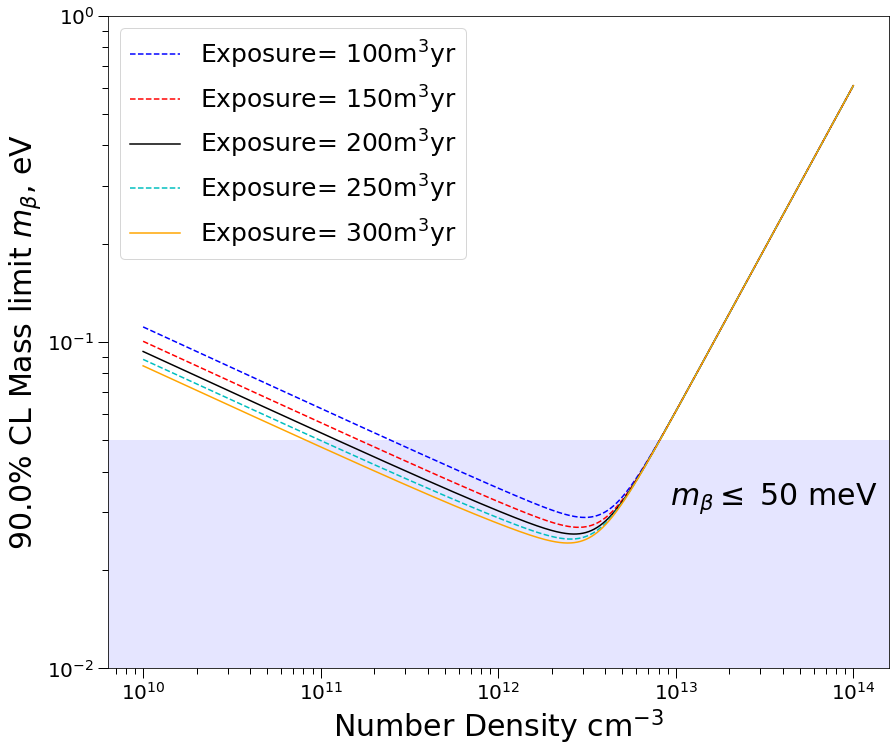

In [21]:
#n = [8.00e+10,7.00e+11,1.00e+12,3.00e+12,5.00e+12]
#vol = np.logspace(-6,6,num = 2000)
b = 1.00e-6
B = t = eff = 1.00
exp = []
rmsB = 1.00e-7
rmsI = 1.00e-7
ui = 1.00e-2
ub = us = 1.00e-2
cl = 0.90
n2 = np.logspace(10,14,num = 2000)
vol = [100,150,200,250,300]

nm1 = NMevars("A",n2,vol[0],b,t,eff,B,rmsB,ub,us,rmsI,ui).MSndensity(cl)
nm2 = NMevars("A",n2,vol[1],b,t,eff,B,rmsB,ub,us,rmsI,ui).MSndensity(cl)
nm3 = NMevars("A",n2,vol[2],b,t,eff,B,rmsB,ub,us,rmsI,ui).MSndensity(cl)
nm4 = NMevars("A",n2,vol[3],b,t,eff,B,rmsB,ub,us,rmsI,ui).MSndensity(cl)
nm5 = NMevars("A",n2,vol[4],b,t,eff,B,rmsB,ub,us,rmsI,ui).MSndensity(cl)
fig = plt.figure(figsize = (14,12))
plt.plot(n2,nm1, "b--")
plt.plot(n2,nm2, "r--")
plt.plot(n2,nm3, "k")
plt.plot(n2,nm4, "c--")
plt.plot(n2,nm5, "orange")
#plt.ylim((1e-2,1e-1))
plt.xscale("log")
plt.yscale("log")
plt.xticks(size = 20)
plt.yticks(size = 20)
plt.ylim((1e-2,1e0))

plt.xlabel("Number Density cm$^{{-3}}$", size = 30)
plt.ylabel(f"{cl*100}% CL Mass limit $m_\\beta$, eV", size = 30)
plt.tick_params(axis = 'both', which = 'major',length = 10, width = 1)
plt.tick_params(axis = 'both', which = 'minor',length = 6, width = 1)
plt.axhspan(1e-2,5e-2,facecolor='blue', alpha=0.1)
ax = plt.subplot(111)
t = plt.text(0.72, 0.25, '$m_\\beta \\leq$ 50 meV', transform=ax.transAxes, fontsize=30)
t.set_bbox(dict(facecolor='none', alpha=0.1, edgecolor='none'))
legends = []
for i in range(len(vol)):
    legends.append(f'Exposure= {vol[i]}m$^{{3}}$yr')
plt.legend(legends, fontsize = 25)





## $m_\beta$ as a function of uncertainty in instrument resolution

0.02848286913987991

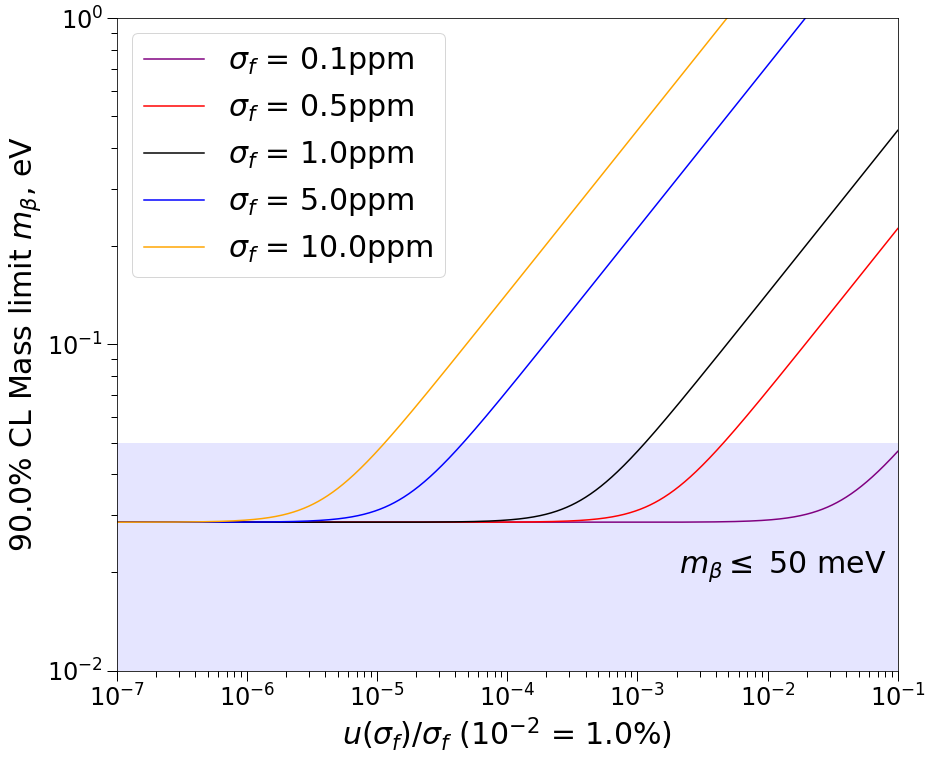

In [22]:
ub = np.logspace(-7,-1,num = 2000)
ui = 1.00e-2
vol = 100
rmsB = [1.00e-7,5.00e-7,1.00e-6,5.00e-6,1.00e-5]
ppm = [0.1,0.5,1.0,5.0,10.0]
b = 1.00e-6
us = 1.00e-2
B = t = eff = 1.00
nm1 = NMuvars1("A",3070744069776.8584,vol,b,t,eff,B,rmsB[0],ub,us,1.00e-7,ui).MSmagnetic(cl)
nm2 = NMuvars1("A",3070744069776.8584,vol,b,t,eff,B,rmsB[1],ub,us,1.00e-7,ui).MSmagnetic(cl)
nm3 = NMuvars1("A",3070744069776.8584,vol,b,t,eff,B,rmsB[2],ub,us,1.00e-7,ui).MSmagnetic(cl)
nm4 = NMuvars1("A",3070744069776.8584,vol,b,t,eff,B,rmsB[3],ub,us,1.00e-7,ui).MSmagnetic(cl)
nm5 = NMuvars1("A",3070744069776.8584,vol,b,t,eff,B,rmsB[4],ub,us,1.00e-7,ui).MSmagnetic(cl)
fig = plt.figure(figsize = (14,12))
plt.plot(ub,nm1, "purple")
plt.plot(ub,nm2, "r")
plt.plot(ub,nm3, "k")
plt.plot(ub,nm4, "b")
plt.plot(ub,nm5, "orange")
plt.xlim((1e-7,1e-1))
plt.ylim((1e-2,1e-0))
plt.xscale("log")
plt.yscale("log")
plt.xticks(size = 24)
plt.yticks(size = 24)
plt.xlabel("$u(\\sigma_f)/\\sigma_f$ (10$^{-2}$ = 1.0%)", size = 30)
plt.ylabel(f"{cl*100}% CL Mass limit $m_\\beta$, eV", size = 30)
plt.tick_params(axis = 'both', which = 'major',length = 10, width = 1)
plt.tick_params(axis = 'both', which = 'minor',length = 6, width = 1)
plt.axhspan(1e-2,5e-2,facecolor='blue', alpha=0.1)
#plt.axvspan(8e-4,1e-3,facecolor='blue', alpha=0.1)
ax = plt.subplot(111)
t = plt.text(0.72, 0.15, '$m_\\beta \\leq$ 50 meV', transform=ax.transAxes, fontsize=30)
t.set_bbox(dict(facecolor='none', alpha=0.1, edgecolor='none'))
legends = []
for i in range(len(ppm)):
    legends.append(f'$\\sigma_f$ = {ppm[i]}ppm')
plt.legend(legends, fontsize = 30)
nm4[0]

## $m_\beta$ as a function of instrument resolution

0.0284825847169764

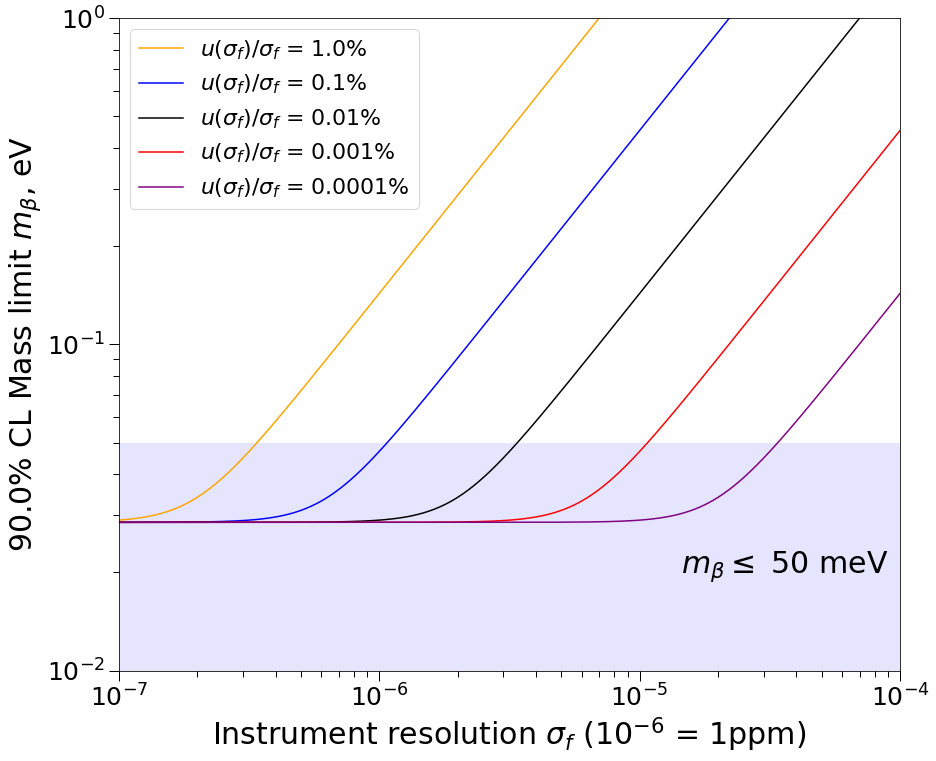

In [23]:
B = 1.00
t = eff = 1.00
vol = 100
n = 3070744069776.8584
us = 1.00e-2
ub = [1.00e-2,1.00e-3,1.00e-4,1.00e-5,1.00e-6]
ui = 1.00e-2
rmsB = np.logspace(-7,-4,num = 2000)
ppm = [1.0000,0.1000,0.0100,0.0010,0.0001]
cl = 0.90

nm1 = NMuvars2("A",n,vol,b,t,eff,B,rmsB,ub[0],us,rmsI,ui).MSres_magnetic(cl)
nm2 = NMuvars2("A",n,vol,b,t,eff,B,rmsB,ub[1],us,rmsI,ui).MSres_magnetic(cl)
nm3 = NMuvars2("A",n,vol,b,t,eff,B,rmsB,ub[2],us,rmsI,ui).MSres_magnetic(cl)
nm4 = NMuvars2("A",n,vol,b,t,eff,B,rmsB,ub[3],us,rmsI,ui).MSres_magnetic(cl)
nm5 = NMuvars2("A",n,vol,b,t,eff,B,rmsB,ub[4],us,rmsI,ui).MSres_magnetic(cl)

ppm2 = []
for i in range(len(rmsB)):
    ppm2.append(rmsB[i]*1.00e+7)


fig = plt.figure(figsize = (14,12))
plt.plot(rmsB,nm1, "orange")
plt.plot(rmsB,nm2, "b")
plt.plot(rmsB,nm3, "k")
plt.plot(rmsB,nm4, "r")
plt.plot(rmsB,nm5, "purple")
plt.ylim((1e-2,1e-0))
plt.xscale("log")
plt.yscale("log")
plt.xticks(size = 25)
plt.yticks(size = 25)
plt.xlim((1e-7,1e-4))
plt.xlabel("Instrument resolution $\\sigma_f$ ($10^{{-6}}$ = 1ppm)", size = 30)
plt.ylabel(f"{cl*100}% CL Mass limit $m_\\beta$, eV", size = 30)
plt.tick_params(axis = 'both', which = 'major',length = 10, width = 1)
plt.tick_params(axis = 'both', which = 'minor',length = 6, width = 1)
plt.axhspan(1e-2,5e-2,facecolor='blue', alpha=0.1)
ax = plt.subplot(111)
t = plt.text(0.72, 0.15, '$m_\\beta \\leq$ 50 meV', transform=ax.transAxes, fontsize=30)
t.set_bbox(dict(facecolor='none', alpha=0.1, edgecolor='none'))
plt.ylabel(f"{cl*100}% CL Mass limit $m_\\beta$, eV", size = 30)
legends = []
for i in range(len(ppm)):
    legends.append(f'$u(\\sigma_f)/\\sigma_f$ = {ppm[i]}%')
plt.legend(legends, fontsize = 22)
nm4[0]

In [24]:
NMfinmass("A",3070744069776.8584,100,1.00e-6,1.00,1.00,1.00,1.00e-7,1.00e-2,1.00e-2,3.00e-6,1.00e-4,0.90)
   

44.91744256403448 meV


In [25]:
NMfinmass("A",3070744069776.8584,100,1.00e-6,1.00,1.00,0.50,1.00e-7,1.00e-2,1.00e-2,5.00e-6,4.00e-5,0.90)
   

48.43397764956333 meV
